# Please, Act! 
Politicians Lie Everytime About Subjects on the Environment, Acknowledge Climate Transformation !

## Abstract

Now more than ever, climate change is a very hotly debated topic which often comes up in the news. This year alone, the Intergovernmental Panel on Climate Change and World Meteorological Organization released very alarming reports stating that we are "way behind" on the objectives of the Paris Agreement. While there will be some individual action involved if we are to tackle the climate crisis, laws and regulations passed by governments will be imperative to avoid the worst case scenario. Using the Quotebank dataset, we were interested to see whether climate change is used as a campaign promise by politicians or if it really is a subject that is constantly talked about. Furthermore, which political groups are the most involved in proposing solutions and spreading awareness about the pressing climate crisis that we are facing. More importantly: do they Act?

## Research questions
Research questions: Who speaks the most about climate change? What is their position on the subject? Do politicians all have the same words and opinions on the subject ? What factors affect this position? What are the periods when the subject is most highlighted, and at the heart of the debates ? Do voting periods have an impact? Does speaking about the problem mean taking action?

## Datasets

* Quotebank
* Informations about the speakers from the Wikidata knowledge base
* Dataset containing an environmental index for each state: <a href='https://www.governing.com/next/what-is-the-greenest-most-environmentally-friendly-state.html'> link </a>
* Dataset containing the CO2 emissions of each states: <a href='https://www.wri.org/data/climate-watch-historical-emissions-data-countries-us-states-unfccc'> link </a>
* Dataset of the senators and governors
* Dataset of events

# Table of contents
<a id = table_of_contents></a>
1. [Load the data](#load_data)


2. [Temporal Analysis](#temporal_analysis)


3. [Semantique Analysis](#semantique_analysis)
    - [3.1 LDA](#LDA)
    - [3.1 Word cloud](#word_cloud)
    - [3.3 Distribution of quotes by party in each topic](#quotes_party_topic)
  
 
4. [Political Analysis](#political_analysis)
    - [4.1 How political parties talk about climate change?](#political_talking)
    - [4.2 Score of durability of each states](#score_durability)
    - [4.3 CO2 emissions of each states](#CO2_emissions)
    - [4.4 Does talking leads to actions?](#talking_action)
    - [4.5 Interactive map](#interactive_map)
    

5. [Conclusion](#conclusion)

In [4]:
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pyarrow.parquet as pq
import geopandas

ModuleNotFoundError: No module named 'geopandas'

In [178]:
import warnings
warnings.filterwarnings("ignore")

<a id = load_data></a>
## 1. Load the Data

In [ ]:
data2020 = pd.DataFrame()
data2019 = pd.DataFrame()
data2018 = pd.DataFrame()
data2017 = pd.DataFrame()
data2016 = pd.DataFrame()
data2015 = pd.DataFrame()

def process_chunk(chunk):
        print(f'Processing chunk with {len(chunk)} rows')
        data = pd.DataFrame()
        
        # Take only the quotes about climate change
        keywords = ["limate change", "lobal warming", "COP", "limate variation", "limate crisis", "CO2 emissions", 
                    "reenhouse effect", "reenhouse gas", "limate emergency", "nvironmental crisis"]
        mask = chunk.quotation.apply(lambda x: any(word in x for word in keywords))
        data = chunk[mask]

        print("Number of filtered quotes {} out of {}".format(len(data), len(chunk)))
        data[['quotation', 'speaker']].head()
        
        # Drop quotes without speaker
        no_speaker = data[data.speaker == "None"].index
        data = data.drop(no_speaker)
        print("{} quotes are removed".format(len(no_speaker)))
        
        # Drop useless informations
        del data["probas"]
        del data["phase"]
        del data["qids"]
        del data["urls"]


        return data
    

with pd.read_json('quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=1000000) as df_reader:
    for chunk in df_reader:    
        data2020 = data2020.append(process_chunk(chunk))

with pd.read_json('quotes-2019.json.bz2', lines=True, compression='bz2', chunksize=1000000) as df_reader:
    for chunk in df_reader:    
        data2019 = data2019.append(process_chunk(chunk))       


with pd.read_json('quotes-2018.json.bz2', lines=True, compression='bz2', chunksize=1000000) as df_reader:
    for chunk in df_reader:    
        data2018 = data2018.append(process_chunk(chunk))
        

with pd.read_json('quotes-2017.json.bz2', lines=True, compression='bz2', chunksize=1000000) as df_reader:
    for chunk in df_reader:    
        data2017 = data2017.append(process_chunk(chunk))
        

with pd.read_json('quotes-2016.json.bz2', lines=True, compression='bz2', chunksize=1000000) as df_reader:
    for chunk in df_reader:    
        data2016 = data2016.append(process_chunk(chunk))
        

with pd.read_json('quotes-2015.json.bz2', lines=True, compression='bz2', chunksize=1000000) as df_reader:
    for chunk in df_reader:    
        data2015 = data2015.append(process_chunk(chunk))
        

## Saving data as pickle

data2020.to_pickle("./data2020.pkl")
data2019.to_pickle("./data2019.pkl")
data2018.to_pickle("./data2018.pkl")
data2017.to_pickle("./data2017.pkl")
data2016.to_pickle("./data2016.pkl")
data2015.to_pickle("./data2015.pkl")

Load data from the pickle files

In [80]:
data2020 = pd.read_pickle('data2020.pkl', compression='infer')
data2019 = pd.read_pickle('data2019.pkl', compression='infer')
data2018 = pd.read_pickle('data2018.pkl', compression='infer')
data2017 = pd.read_pickle('data2017.pkl', compression='infer')
data2016 = pd.read_pickle('data2016.pkl', compression='infer')
data2015 = pd.read_pickle('data2015.pkl', compression='infer')

In [81]:
data = data2020
data = data.append(data2019, ignore_index=True)
data = data.append(data2018, ignore_index=True)
data = data.append(data2017, ignore_index=True)
data =data.append(data2016, ignore_index=True)
data = data.append(data2015, ignore_index=True)
len(data)

135492

In [82]:
#read QID csv
QID = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [83]:
#read parquet file
speaker_df = pd.read_parquet("speaker_attributes.parquet", engine='pyarrow')

In [84]:
#removing duplicates on 'label'
speaker_df=speaker_df.drop_duplicates(subset=['label'])

<a id = temporal_analysis></a>
## 2. Temporal Analysis

In [162]:
# Copying the data
df_TA = data

In [157]:
df_time = df_TA.groupby(pd.Grouper(freq='W-MON', key='date'), as_index=True).count() # or .sum(), dunno which is better
df_time = df_time.rename(columns={'numOccurrences':'val'})

In [158]:
ev = pd.read_csv("./events.csv", delimiter=';')
ev['Date'] = pd.to_datetime(ev['Date'], format="%d/%m/%Y")
ev['date_ann'] = ev['Date'].dt.to_period('W-mon').apply(lambda r: r.end_time.date())
ev['date_ann'] = ev['date_ann'].astype('datetime64[ns]')

ev

,Name,Date,Type,Comment,Unnamed: 4,Unnamed: 5,Unnamed: 6,date_ann
0,COP 21,2015-12-07,1,NaN,NaN,NaN,NaN,2015-12-07
1,COP 22,2016-11-07,1,NaN,NaN,NaN,NaN,2016-11-07
2,COP 23,2017-11-12,1,NaN,NaN,NaN,NaN,2017-11-13
3,COP 24,2018-12-02,1,NaN,NaN,NaN,NaN,2018-12-03
4,COP 25,2019-12-09,1,NaN,NaN,NaN,NaN,2019-12-09
5,G20 2016,2016-09-05,1,NaN,NaN,NaN,NaN,2016-09-05
6,G20 2017,2017-07-07,1,NaN,NaN,NaN,NaN,2017-07-10
7,G20 2018,2018-11-30,1,NaN,NaN,NaN,NaN,2018-12-03
8,G20 2019,2019-06-28,1,NaN,NaN,NaN,NaN,2019-07-01
9,Primary elections 2016,2016-05-30,2,Février à Juin 2016,24/04/2016 -,NaN,NaN,2016-05-30


In [159]:
def add_annotation(fig, df_time, date, text, bgcolor):   
    fig.add_annotation(
            x=date,
            y=df_time.loc[date].val,
            hovertext=text,
            showarrow=True,
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            borderwidth=4,
            borderpad=4,
            opacity=0.8,
            bgcolor=bgcolor,
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="#ffffff"
            ),
            )

In [160]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

c_cop = "#2f669c"
c_pol = "#9c342f"
c_cli = "#2f9c3d"

colors=[c_cop, c_pol, c_cli]
topics=["Governmental Events", "Politics", "Climate Catastrophe"]

fig.add_trace(go.Scatter(x=df_time.index, y=df_time.val, name="", showlegend=False))
for i in range (0,3):
    ev_s = ev.loc[ev.Type == i+1]
    fig.add_trace(go.Scatter(x=ev_s['date_ann'], y=df_time.loc[ev_s.date_ann].val, 
                             mode="markers",
                             marker=dict(
                                 size=10, color=colors[i]),
                             name=topics[i], showlegend=True,
                            hoverinfo="text",
                            text=ev_s['Name']))

fig.update_xaxes(rangeslider_visible=True)

"""
for r in ev.iterrows():
    add_annotation(fig, df_time, r[1]['date_ann'], r[1]["Name"], colors[r[1]["Type"]-1])
"""
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.update_layout(width=800, height=600)
fig.show()

In [161]:
fig.write_html('./time_series.html')

<a id = semantique_analysis></a>
## 3. Semantique Analysis

<a id = LDA></a>
##### 3.1 LDA

In [179]:
np.random.seed(11172613)

In [180]:
# Copying the data for the LDA task
df_LDA = data
df_LDA.head()

,quoteID,quotation,speaker,date,numOccurrences
0,2020-01-29-062975,Many make the link today between their experie...,Peter Maurer,2020-01-29 09:04:36,5
1,2020-02-10-076321,the National Energy and Climate Plans are how ...,Kadri Simson,2020-02-10 05:51:51,1
2,2020-01-06-069057,"This budget also allows us to earmark £ 500,00...",John Whitehead,2020-01-06 11:49:00,1
3,2020-03-10-005294,"As a state, we will pursue every option availa...",Kate Brown,2020-03-10 20:47:28,2
4,2020-02-11-027545,how will you inspire Americans who have given ...,Amy Klobuchar,2020-02-11 12:29:43,1


In [181]:
docs = df_LDA['quotation'].to_numpy()

In [182]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [183]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

docs = [[token for token in doc if not token in stopwords ] for doc in docs]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sandy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [184]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sandy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [185]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [186]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [187]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=1)

In [188]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [189]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 8843
Number of documents: 135492


In [190]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = 1  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    for num_topics in range(start, limit, step):
        print("Current pass {}".format(num_topics))
        model =  models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
        )        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [191]:
from gensim import models

In [192]:
import gensim
from gensim.models import CoherenceModel
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)

Current pass 2
Current pass 8
Current pass 14
Current pass 20
Current pass 26
Current pass 32
Current pass 38


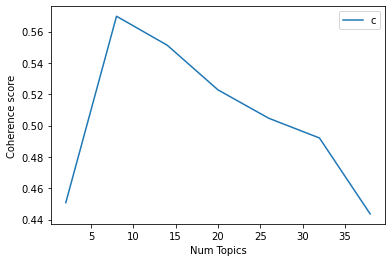

In [193]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

The optimal number of topics is 8.

In [194]:
# Train LDA model.
from gensim.models import LdaModel
np.random.seed(6080)
# Set training parameters.
num_topics = 8
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [74]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
top_topics

Average topic coherence: -4.0283.


[([(0.12819447, 'climate'),
   (0.11950742, 'change'),
   (0.015576311, 'world'),
   (0.011802828, 'need'),
   (0.01054662, 'u'),
   (0.010542016, 'issue'),
   (0.010291302, 'country'),
   (0.009737601, 'people'),
   (0.008827103, 'action'),
   (0.008073371, 'make'),
   (0.0080207875, 'future'),
   (0.00708607, 'way'),
   (0.006977066, 'challenge'),
   (0.0068982826, 'government'),
   (0.006608826, 'important'),
   (0.006545409, 'also'),
   (0.0063193687, 'state'),
   (0.006307283, 'problem'),
   (0.0056905206, 'take'),
   (0.0056309984, 'real')],
  -2.734538788237368),
 ([(0.059762333, 'emission'),
   (0.058870215, 'gas'),
   (0.05622275, 'energy'),
   (0.052672718, 'greenhouse'),
   (0.037744284, 'greenhouse_gas'),
   (0.030666545, 'carbon'),
   (0.022382168, 'reduce'),
   (0.018526727, 'clean'),
   (0.013380813, 'power'),
   (0.011896119, 'pollution'),
   (0.01132421, 'co2'),
   (0.011080572, 'cost'),
   (0.010825422, 'renewable'),
   (0.010813813, 'reducing'),
   (0.010725808, 'red

In [75]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [76]:
viz_data = gensimvis.prepare(model, corpus, dictionary)

In [78]:
pyLDAvis.display(viz_data)

In [79]:
pyLDAvis.save_html(viz_data, 'LDAvis.html')

In [86]:
classes = []
for i in range(len(df_LDA)):
    classes.append(max(model.get_document_topics(corpus[i]), key=lambda t: t[1])[0])

df_LDA['class'] = classes

In [87]:
df_LDA.head()

,quoteID,quotation,speaker,date,numOccurrences,class
0,2020-01-29-062975,"[many, make, the, link, today, between, their,...",Peter Maurer,2020-01-29 09:04:36,5,1
1,2020-02-10-076321,"[the, national, energy, and, climate, plans, a...",Kadri Simson,2020-02-10 05:51:51,1,1
2,2020-01-06-069057,"[this, budget, also, allows, us, to, earmark, ...",John Whitehead,2020-01-06 11:49:00,1,1
3,2020-03-10-005294,"[as, a, state, we, will, pursue, every, option...",Kate Brown,2020-03-10 20:47:28,2,1
4,2020-02-11-027545,"[how, will, you, inspire, americans, who, have...",Amy Klobuchar,2020-02-11 12:29:43,1,1


In [89]:
speakers_per_class = pd.DataFrame(df_LDA.groupby('class')['speaker'].value_counts())
speakers_per_class = speakers_per_class.rename({'speaker':'count'}, axis='columns')

In [90]:
speakers_per_class.reset_index()

,class,speaker,count
0,0,Michael Mann,54
1,0,Terry Hughes,27
2,0,Noah Diffenbaugh,25
3,0,Petteri Taalas,25
4,0,President Obama,21
...,...,...,...
38512,7,Zhu Liu,1
38513,7,Zou Ji,1
38514,7,ed king,1
38515,7,fund manager,1


In [91]:
speakers_per_class.groupby('class').head()

count
class speaker                      
0     Michael Mann               54
      Terry Hughes               27
      Noah Diffenbaugh           25
      Petteri Taalas             25
      President Obama            21
1     Bernie Sanders           1119
      President Barack Obama    824
      Narendra Modi             749
      Justin Trudeau            671
      Jay Inslee                648
2     Scott Pruitt               25
      John Cook                  10
      Donald Trump                9
      Michael Mann                9
      Noah Diffenbaugh            9
3     Bernie Sanders             83
      Bill McKibben              17
      Bill de Blasio             14
      Joaquin Phoenix            13
      Michael Mann               10
4     Scott Pruitt              115
      Michael Mann              109
      Donald Trump              102
      Ted Cruz                   80
      Bernie Sanders             66
5     Scott Pruitt               16
      Andrew Wheeler              9
      Gavin Newsom                4
      Mark Carney                 4
      Michael Bloomberg           4
6     Laurent Fabius              2
      James Kenney                1
7     Gina McCarthy              54
      Charlie Baker              36
      Andrew Wheeler             34
      Dustin Duncan              32
      Jerry Brown                31

In [92]:
speakers_to_save = speakers_per_class.groupby('class')

In [93]:
speakers_per_class.to_pickle("speaker_per_class.pkl")

In [94]:
df_LDA.to_pickle("quotes_topic_associated.pkl")

#### Conclusion of LDA:


<a id = word_cloud></a>
##### 3.2 Word Cloud

In [98]:
from wordcloud import WordCloud, ImageColorGenerator

In [99]:
vocab =['climate','change','people','crisis','need','issue','action','one','like','time','way','make','going','think','take','would','want','know','thing'
       'impact','year','effect','human','water','level','already','weather','fire','future','extreme','event','next','increase','last','may','area','also','generation', 'decade'
       'world','country','challenge','threat','state','around','work','face','today','together','leader','australia','nation','forward','first','facing','agreement','international','leadership','start'
       'global','warming','global_warming','president','trump','zero','everything','administration','net_zero','degree','net','house','made','limit','man','called','customer','person','bit','donald'
       'emergency','fuel','fossil','fossil_fuel','line','energy','kid','front','news','story','burning','prime', 'minister','middle','remain','class','changed','type','transform','front_line'
       'development','sustainable','resource','security','natural']

In [100]:
#Give our USA corpus a variable name
usa_corpus = " ".join(vocab)

In [111]:
from PIL import Image

In [112]:
usa_mask = np.array(Image.open('usa.jpg'))

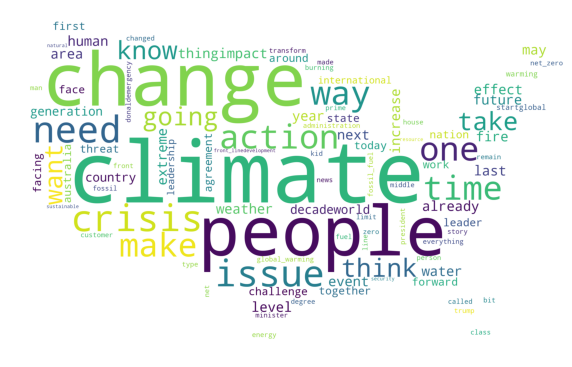

<Figure size 432x288 with 0 Axes>

In [113]:
def generate_better_wordcloud(data, title, mask=None):
    cloud = WordCloud(scale=3,
                      max_words=250,
                      colormap='viridis',
                      mask=mask,
                      background_color='white',
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(10,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title)
    plt.show()
    plt.savefig('usa_map.png')
    
# Use the function with the rome_corpus and our mask to create word cloud     
generate_better_wordcloud(usa_corpus, '', mask=usa_mask)

<a id = quotes_party_topic></a>
##### 3.3 Distribution of quotes by party in each topic

In [117]:
#Copying data
df_dist = data

In [163]:
# We open the dataframe with each quote associated to a topic from the end of the LDA file
df_dist = pd.read_pickle('quotes_topic_associated.pkl')

In [164]:
# rename in order to make next merge on speaker attribute
df_dist = df_dist.rename(columns={'speaker': 'label'})

In [165]:
df_dist.head()

,quoteID,quotation,label,date,numOccurrences,class
5265,2015-08-19-056730,"[it, s, very, important, to, understand, how, ...",Helen McGregor,2015-08-19 11:46:00,2,2
5891,2015-09-28-067347,"[man, made, emissions, are, an, insignificant,...",John Abraham,2015-09-28 23:16:52,1,7
7868,2015-09-29-052783,"[in, the, final, months, before, crucial, clim...",Bill de Blasio,2015-09-29 16:10:01,1,7
9207,2015-10-29-104475,"[the, baker, polito, administration, is, fully...",Peter Lorenz,2015-10-29 10:49:41,3,3
9709,2015-05-07-042445,"[the, general, narrative, is, addressing, clim...",Dallas Burtraw,2015-05-07 17:55:43,2,7


In [167]:
# We merge our dataframe on the speaker with the speaker dataframe in order to retrive speaker's Political party
df_merged = pd.merge(df_dist, speaker_df, how='left', on='label')

In [168]:
# Some speakers are associated to multiple parties, we expand them in order to have a single party per quote
df_merged = df_merged.dropna(subset=['party']).explode(column='party')

In [169]:
# We remove useless attributes
df_merged = df_merged.drop(['nationality', 'aliases', 'date_of_birth', 'gender', 'lastrevid', 'ethnic_group','US_congress_bio_ID', 'academic_degree', 'religion', 'date','type', 'candidacy' ], axis=1)

In [170]:
# Rename in order to merge with QID dataset
df_merged = df_merged.rename(columns={'party': 'QID'})

In [171]:
df_new = pd.merge(df_merged, QID, on='QID')

In [172]:
df_new.dropna(inplace=True)

In [173]:
# We keep only american parties
df_new = df_new[df_new['Description'].str.contains('United States')]

In [174]:
# Main Instruction : 
# Counting for each class (i.e 'Topic') the frequency (normalize=True) of quotes per political party
# and we store it in 'Frequency of quotes'
df_frequencies = df_new.groupby('class')['Label'].value_counts(normalize=True, sort=True, ascending=False).to_frame('Frequency of Quotes')

In [175]:
df_frequencies = df_frequencies.reset_index()

# Remove marginal parties : less than 1.5% 
df_frequencies = df_frequencies[df_frequencies.reset_index()['Frequency of Quotes']>0.015]

# Give meaningful names to attributes
df_frequencies = df_frequencies.rename(columns={'class': 'Topic','Label':'Party' })

# To recover the topic's numbers
df_frequencies['Topic'] = df_frequencies['Topic'] + 1

In [176]:
df_frequencies

,Topic,Party,Frequency of Quotes
0,1,Democratic Party,0.666667
1,1,Republican Party,0.333333
2,2,Republican Party,0.777778
3,2,Democratic Party,0.222222
4,3,Republican Party,0.809211
5,3,Democratic Party,0.184211
7,4,Democratic Party,0.827149
8,4,Republican Party,0.159276
11,5,Democratic Party,0.640000
12,5,Republican Party,0.360000


In [177]:
import plotly.express as px
fig = px.bar(df_frequencies, x="Party", y="Frequency of Quotes", color="Party", barmode="group",
             facet_col="Topic", width=900, height=500, title="Distribution of quotes by Party in each Topic")
fig.update_layout(
    title={
        'text': "Distribution of quotes by Party in each Topic",
        'y':0.9,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()
#fig.write_html("frequencies_per_topic.html")

## 4. Political Analysis
<a id = political_analysis></a>

In [136]:
# Copying de data
data_climate = data

In [137]:
## Subset of the climate quotes containing specific meaningful words
data_crisis = data_climate[data_climate['quotation'].str.contains('Crisis|crisis')]

data_economic = data_climate[data_climate['quotation'].str.contains('economic|economy|Economy|Economic|business')]

<a id = political_talking> </a>
### 4.1 How political parties talk about climate change?
    1. How are the parties represented in this climate quotes dataset?

In [138]:
#sort speakers from the one with the most quotes to the least
sorted_speakers = data_climate['speaker'].value_counts().to_frame('counts').reset_index()
sorted_speakers = sorted_speakers.rename(columns = {'index': 'label'})

In [139]:
#merge classement above and the parquet file
top_speakers_inorder = pd.merge(sorted_speakers, speaker_df, how='left', on='label')

In [140]:
#Get the infos in the QID file
party = top_speakers_inorder[['party','counts']]
party = party.explode(column='party')
party = party.rename(columns={'party': 'QID'})
party = party.dropna()

#counts number of occurence of each QID label for the party
party = party.groupby(['QID'])['counts'].sum().to_frame()
party = party.sort_values(by='counts',ascending=False)

In [141]:
final = pd.merge(party, QID, on='QID')
final = final.sort_values(by='counts',ascending=False)

## take only parties from the USA
final = final.dropna()
final = final[final['Description'].str.contains('United States')]

## group minorities in categorie 'others'
other = final.loc[final['counts']<300].sum()
final = final[final['counts'] > 300]
final = final.append(other, ignore_index=True)
final.at[2,'Label']='Others'
final

,counts,Label,Description
0,19494,Democratic Party,political party in the United States
1,7767,Republican Party,major political party in the United States
2,420,Others,"political party in Minnesota, United Statesnat..."


In [142]:
import plotly.graph_objects as go

labels = final['Label']
values = final['counts']

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title='Repartition of the quotes about climate change',width=450, height=450)
fig.show()
fig.write_html("pie_chart.html")

    2. Which proportion of democrates/republican quotes contains specific meaningful words?

The goal here is to see which proportion some words from the LDA topics founds above take in the climate dataset. We choose to tackle the first 2 topics. From the first one, we use the word 'crisis' and for the second one 'business'.

In [143]:
#crisis
sorted_speakers_crisis = data_crisis['speaker'].value_counts().to_frame('counts').reset_index()
sorted_speakers_crisis = sorted_speakers_crisis.rename(columns={'index': 'label'})

top_speakers_crisis = pd.merge(sorted_speakers_crisis, speaker_df, how='left', on='label')

In [144]:
#business
sorted_business = data_economic['speaker'].value_counts().to_frame('counts').reset_index()
sorted_business = sorted_business.rename(columns={'index': 'label'})

top_speakers_business = pd.merge(sorted_business, speaker_df, how='left', on='label')

In [145]:
party_crisis = top_speakers_crisis[['party','counts']]
party_crisis = party_crisis.explode(column='party')
party_crisis = party_crisis.rename(columns={'party': 'QID'})
party_crisis = party_crisis.dropna()

party_crisis = party_crisis.groupby(['QID'])['counts'].sum().to_frame()
party_crisis = party_crisis.sort_values(by='counts',ascending=False)

In [146]:
party_business = top_speakers_business[['party','counts']]
party_business = party_business.explode(column='party')
party_business = party_business.rename(columns={'party': 'QID'})
party_business = party_business.dropna()

party_business = party_business.groupby(['QID'])['counts'].sum().to_frame()
party_business = party_business.sort_values(by='counts',ascending=False)

In [147]:
final_crisis = pd.merge(party_crisis, QID, on='QID')
final_crisis = final_crisis.sort_values(by='counts',ascending=False)

In [148]:
final_business = pd.merge(party_business, QID, on='QID')
final_business = final_business.sort_values(by='counts',ascending=False)

In [149]:
business_crisis = pd.merge(final_crisis, final_business, on='Description')

In [150]:
bar = pd.merge(business_crisis, final, on='Description')

In [151]:
bar['percentage_crisis'] = bar['counts_x']/bar['counts']
bar['percentage_business'] = bar['counts_y']/bar['counts']

In [152]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    y = bar['percentage_crisis'],
    x = bar['Label_x'],
    name ='Use of word "crisis"',
   
    )
)
fig.add_trace(go.Bar(
   y = bar['percentage_business'],
   x = bar['Label_x'],
   name ='Use of word "business"',
    
)
             )
  


fig.update_layout(barmode='group', width=520, height=450, title='Proportion of quotes containing meaningful words')
fig.show()
fig.write_html("bar_chart_words.html")

<a id=score_durability></a>
### 4.2 Score of durability of each state

We aim to get an idea of the actions taken agains global warming for each state in the US. We use here dataset containing an environmental index for each state. This is a report from WalletHub from 2021 that gives an environmental score to each state based on three criterias: environmental quality, eco-friendly behavior and climate-change contributions.


In [154]:
#read file containing durability score
scores = pd.read_csv('states_scores.csv', delimiter=';')

#normalize values too be able to compare with other datas later
max_value = scores['score'].max()
min_value = scores['score'].min()
scores['score'] = (scores['score'] - min_value) / (max_value - min_value)

In [155]:
#creating the map using geopandas and a shapefile of the US
states = geopandas.read_file('data/usa-states-census-2014.shp')
states = states.rename(columns={'NAME': 'state'})
states = states.to_crs(epsg=3395)

#merge with states_scores
geo_scores = pd.merge(states, scores, how='left', on='state')

NameError: name 'geopandas' is not defined

In [ ]:
#plot map with geopandas
fig, ax = plt.subplots(1, figsize=(10,6))
geo_scores.plot(column='score', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')
plt.show()

<a id= CO2_emissions> </a>
### 4.3 CO2 emissions of each state

Co2 emissions are another indicator of the state actions against global warming. We use there the CO2 per capita (in metric tons) for each state. The data comes from The World ressource institute, and the most recent values we could find are from 2018.


In [ ]:
emissions = pd.read_csv('emissions.csv', delimiter=',')
emissions = emissions.rename(columns={'Climate Watch - U.S States Greenhouse Gas Emissions':'date', 'Unnamed: 1':'total','Unnamed: 20':'Population'}) 
emissions.drop(emissions.index[:3], inplace=True)

In [ ]:
#emissions per capita
emissions['Co2_cap'] = emissions['total'].astype(float)/emissions['Population'].astype(float)
emissions.reset_index(inplace=True)
emissions = emissions.rename(columns={'index':'state'})

In [ ]:
emissions_2018 = emissions[emissions['date']=='2018']

In [ ]:
#visualisation of the distribution
bar = emissions_2018.sort_values(by='Co2_cap',ascending=False).reset_index()



plt.bar(bar.index, bar['Co2_cap'])
plt.xticks([])
plt.show()

In [ ]:
#visualisation of the distribution in log-scale


plt.bar(bar.index, bar['Co2_cap'], log=True)
plt.xticks([])
plt.show(

In [ ]:
#Use log-value
emissions_2018['log_co2'] = np.log(emissions_2018['Co2_cap'].replace(0, np.nan))

In [ ]:
max_value = emissions_2018['log_co2'].max()
min_value = emissions_2018['log_co2'].min()
emissions_2018['log_co2_norm'] = (emissions_2018['log_co2'] - min_value) / (max_value - min_value)

In [ ]:
#merge with states_scores
geo_co2 = pd.merge(states, emissions_2018, how='left', on='state')

In [ ]:
#plot map with geopandas
fig, ax = plt.subplots(1, figsize=(10,6))
geo_co2.plot(column='log_co2_norm', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')
ax.set_title('Emissions of Co2 per capita')
plt.show()

<a id = talking_action></a>
### 4.4 Talking and actions


Representing the absolute number of quotes about global warming of each state using the governors of each state as reference

In [ ]:
#read file containing governors' names
governors = pd.read_csv('governors.csv', delimiter=';')


governors = governors.dropna(how='all')
governors = governors.rename(columns={'name': 'label', 'party':'political_party', 'state_name':'state'})
governors = governors[['state', 'label', 'political_party']]

In [ ]:
#sort the governors from the one with the most quotes to the less
governors_quotes = pd.merge(governors, sorted_speakers, how='left', on='label')

In [ ]:
governors_quotes.isna().sum()


Number of quotes of each state but using senators as reference

In [ ]:
#read file containing senators names
senators = pd.read_csv('senators.csv', delimiter=';')

senators = senators.rename(columns={'Name': 'label', 'State':'state'})
senators = senators[['label','state']]

In [ ]:
#sort senators from the one with the most quotes to the least
senators_quotes = pd.merge(senators, sorted_speakers, how='left', on='label')
# group them by state
senators_quotes_grouped = senators_quotes.groupby(['state'])['counts'].sum().to_frame()

In [ ]:
##checking if all states are represented
senators_quotes_grouped.isna().sum()

We have now a better representation of the states

Combining senators and governors

In [ ]:
total = senators_quotes.append(governors_quotes)
total = total.groupby(['state'])['counts'].sum().to_frame()

In [ ]:
#visualisation of the distribution
bar = total.sort_values(by='counts',ascending=False)


plt.bar(bar.index, bar['counts'])
plt.xticks([])
plt.show()

We have a heavy tail distribution so it would be nice see the result with a log-scale

In [ ]:
#visualisation of the distribution using a log-scale
bar = total.sort_values(by='counts',ascending=False)

plt.bar(bar.index, bar['counts'], log=True)
plt.xticks([])
plt.show()

In [ ]:


## use a logarithm value to represent data
total['log_abs'] = np.log(total['counts'].replace(0, np.nan))

#normalize between 0 and 1
max_value = total['log_abs'].max()
min_value = total['log_abs'].min()
total['log_abs_norm'] = (total['log_abs'] - min_value) / (max_value - min_value)



In [ ]:
geo_quotes = pd.merge(states, total, how='left', on='state')

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,6))
geo_quotes.plot(column='log_abs_norm', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')
ax.set_title('Number of quotes of each state')
plt.show()


Relative number of quotes about global warming of each states

To get the relative number of quotes of each states, we use the number of quotes about global warming found above and divide it by total the number of quotes (all quotes).


In [ ]:
#read pickle
data = pd.read_pickle("total_quotes.pkl", compression='infer')

In [ ]:
# senators + governors
all_speakers = senators_quotes.append(governors_quotes)

In [ ]:
# count total quotes and group them by speaker
tot_by_speaker = data['speaker'].value_counts().to_frame('counts').reset_index()
tot_by_speaker = tot_by_speaker.rename(columns={'index':'label'})

In [ ]:
relative = pd.merge(all_speakers, tot_by_speaker, how='left', on='label')

relative = relative.groupby(['state'])[['counts_x','counts_y']].sum()
relative['rel'] = relative['counts_x']/relative['counts_y']
# we now have the relative quotes about global warming with respect to the total quotes

In [ ]:
#take the log-value
relative['log_rel'] = np.log(relative['rel'].replace(0, np.nan))

#normalize between 0 and 1
max_value = relative['log_rel'].max()
min_value = relative['log_rel'].min()
relative['log_rel_norm'] = (relative['log_rel'] - min_value) / (max_value - min_value)

In [ ]:
geo_rel = pd.merge(states, relative, how='left', on='state')

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,6))
geo_rel.plot(column='log_rel_norm', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')
plt.show()

<a id = interactive_map></a>
### 4.5 Interactive map grouping all the infos

In [ ]:
import chart_studio.plotly as py
import plotly.offline as po
import plotly.graph_objs as pg
po.offline.init_notebook_mode(connected=True)

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
map_data = pd.merge(total, relative[['rel','log_rel','log_rel_norm']], how='left', on='state')

In [ ]:
map_data = pd.merge(map_data, scores, on='state')
map_data = pd.merge(map_data, states[['STUSPS','state']], on='state')

In [ ]:
map_data = pd.merge(map_data, emissions_2018[['log_co2_norm','state','Co2_cap']], on='state')

In [ ]:
map_data['party'].replace('Republican Party', 0, inplace=True)
map_data['party'].replace('Democratic Party', 1, inplace=True)

In [ ]:
##  After reading this post: https://stackoverflow.com/questions/61750811/dropdown-menu-for-plotly-choropleth-map-plots

map_data = map_data.rename(columns={'log_rel_norm':"climate quotes", 'score':'environmental score', 'log_co2_norm':'CO2 emissions'})
cols_dd = [ "climate quotes", 'environmental score','CO2 emissions']
visible = np.array(cols_dd)

# define traces and buttons
traces = []
buttons = []

for value in cols_dd:
    traces.append(go.Choropleth(
        locations=map_data['STUSPS'], # Spatial coordinates
        z=map_data[value], # Data to be color-coded
        locationmode = 'USA-states',
        colorscale = 'Greens', 
        text = map_data['state'],
        hovertemplate = " %{text} <br> %{z} <extra></extra>",
        colorbar_title=value,
        visible= True if value==cols_dd[0] else False))
    
    buttons.append(dict(label=value,
                        method="update",
                        args=[{"visible":list(visible==value)},
                              {"title":f"<b>{value}</b>"}]))

updatemenus = [{"active":0,
                "buttons":buttons,
               }]

layout = dict(geo = dict(scope='usa'), updatemenus=updatemenus)
# Show figure
fig = go.Figure(data=traces,
                layout=layout)

first_title = cols_dd[0]
fig.update_layout(title=f"<b>{first_title}</b>",title_x=0.5, width=1000,
    height=600)
fig.show()

<a id = conclusion> </a>
# 5 Conclusion
